In [0]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
from glob import glob
from PIL import Image

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

# import warnings
# warnings.filterwarnings("ignore")

print(tf.__version__)

# Set random seeds
np.random.seed(108)

1.15.0


Using TensorFlow backend.


In [0]:
#connect the notebook to the location of the data
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [0]:
# Set the base directory to the current directory extended by the drive location
root_dir = "/content/gdrive/My Drive/"
base_skin_dir = root_dir + '/Kaggle_HAM10000'

# Build a dictionary with image id and path
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# Create a dictionary of abbreviation definitions
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

# Create a dictionary of index codes ordered by representation
lesion_index_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

In [0]:
# Build dataframe
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = tile_df['dx'].map(lesion_index_dict.get)
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
7487,HAM_0002641,ISIC_0034111,nv,histo,40.0,female,back,/content/gdrive/My Drive//Kaggle_HAM10000/HAM1...,Melanocytic nevi,0
2135,HAM_0007242,ISIC_0030047,mel,histo,70.0,female,upper extremity,/content/gdrive/My Drive//Kaggle_HAM10000/HAM1...,Melanoma,1
6039,HAM_0003166,ISIC_0030848,nv,follow_up,50.0,female,foot,/content/gdrive/My Drive//Kaggle_HAM10000/HAM1...,Melanocytic nevi,0


In [0]:
# Make sure tile_df only has 1k samples of melanocytic nevi
nv_df = tile_df[tile_df.dx == 'nv']
nv_df = nv_df[:1000]
tile_df = tile_df[tile_df.dx != 'nv']
tile_df = pd.concat([tile_df, nv_df], ignore_index=True)
tile_df['cell_type'].value_counts()

Melanoma                          1113
Benign keratosis-like lesions     1099
Melanocytic nevi                  1000
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [0]:
# Define a function to crop and resize our images
def crop_resize(path, target_size = 224):
    new_height, new_width = target_size, target_size
    im = Image.open(path).resize((int(target_size*1.3333), target_size), Image.LANCZOS)
    width, height = im.size   # Get dimensions

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    im = im.crop((left, top, right, bottom))
    return np.asarray(im)

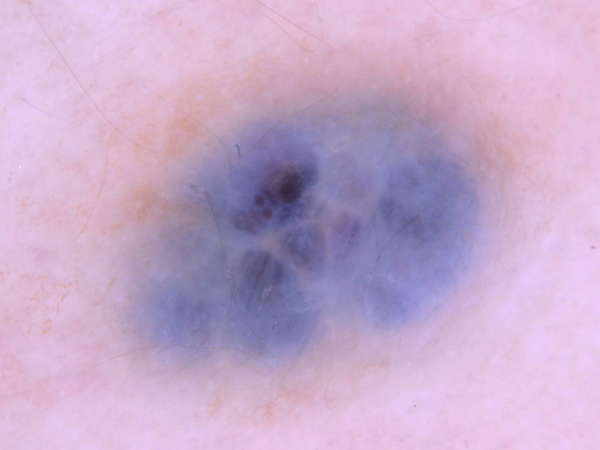

In [0]:
# A sample original image before our crop_resize
example = np.random.choice(4000)
Image.open(tile_df['path'][example])

In [0]:
Image.open(tile_df['path'][example]).size

(600, 450)

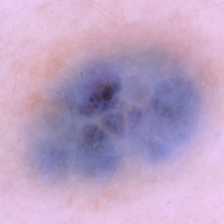

In [0]:
# The same image after processing
Image.fromarray(crop_resize(tile_df['path'][example]))

In [0]:
Image.fromarray(crop_resize(tile_df['path'][example])).size

(224, 224)

In [0]:
# Use our function to load all our treated images into the dataframe 
tile_df['image'] = tile_df['path'].map(lambda x: crop_resize(x))

In [0]:
tile_df.head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/gdrive/My Drive//Kaggle_HAM10000/HAM1...,Benign keratosis-like lesions,2,"[[[201, 165, 198], [202, 163, 199], [203, 161,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/gdrive/My Drive//Kaggle_HAM10000/HAM1...,Benign keratosis-like lesions,2,"[[[149, 118, 148], [152, 123, 151], [157, 126,..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/gdrive/My Drive//Kaggle_HAM10000/HAM1...,Benign keratosis-like lesions,2,"[[[206, 150, 164], [205, 150, 163], [208, 151,..."


In [0]:
tile_df['image'].map(lambda x: x.shape).value_counts()

(224, 224, 3)    4310
Name: image, dtype: int64

In [0]:
# Split into training and testing batches
features=tile_df['image']
target=tile_df['cell_type_idx']

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=108)

In [0]:
# Normalize
x_train = np.asarray(x_train_o.tolist())
x_test = np.asarray(x_test_o.tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [0]:
# Encode labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [0]:
# Set aside a validation set
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 108)

In [0]:
# Reshape
image_shape = tile_df.image[0].shape
x_train = x_train.reshape(x_train.shape[0], *image_shape)
x_test = x_test.reshape(x_test.shape[0], *image_shape)
x_validate = x_validate.reshape(x_validate.shape[0], *image_shape)

# Prepare Transfer Learning Model

In [0]:
# Import vgg16
vgg16_model = keras.applications.vgg16.VGG16()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# Convert vgg16 from type "model" to type "sequential"
model = Sequential()
layer_count = len(vgg16_model.layers)

i = 0
for layer in vgg16_model.layers:
    model.add(layer)
    i += 1
    if i >= len(vgg16_model.layers)-1:
        break  # Don't add the last layer since we want to build our own 

In [0]:
for layer in model.layers[:-7]:
    layer.trainable = False

In [0]:
model.add(Dense(7, activation='softmax'))

In [0]:
# Compile with optimal parameters
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# Reduce learning rate on plateaus to boost performance
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
# Set up early stopping in case our model stops improving
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=2,
                               verbose=1)

In [0]:
# Let's see what we're working with
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [0]:
# Prepare our data generator for augmentation
datagen = ImageDataGenerator(
        rotation_range=10, 
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True)
datagen.fit(x_train)

In [0]:
# It's time to fit our model!
epochs = 10
batch_size = 32
history = model.fit_generator(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    validation_steps=x_validate.shape[0] // batch_size
    # callbacks=[learning_rate_reduction, early_stopping]
)

Epoch 1/10
96/96 [==============================] - 134s 1s/step - loss: 0.5104 - acc: 0.8027 - val_loss: 0.8187 - val_acc: 0.7188
Epoch 2/10
96/96 [==============================] - 136s 1s/step - loss: 0.4967 - acc: 0.8161 - val_loss: 0.8481 - val_acc: 0.7072
Epoch 3/10
96/96 [==============================] - 136s 1s/step - loss: 0.4755 - acc: 0.8244 - val_loss: 0.7315 - val_acc: 0.7362
Epoch 4/10
96/96 [==============================] - 140s 1s/step - loss: 0.4734 - acc: 0.8261 - val_loss: 0.9371 - val_acc: 0.7014
Epoch 5/10
96/96 [==============================] - 137s 1s/step - loss: 0.4438 - acc: 0.8288 - val_loss: 0.8474 - val_acc: 0.7072
Epoch 6/10
96/96 [==============================] - 136s 1s/step - loss: 0.4742 - acc: 0.8241 - val_loss: 0.9632 - val_acc: 0.6928
Epoch 7/10
96/96 [==============================] - 137s 1s/step - loss: 0.4994 - acc: 0.8251 - val_loss: 0.7853 - val_acc: 0.7333
Epoch 8/10
96/96 [==============================] - 137s 1s/step - loss: 0.4378 - a

In [0]:
# Evaluation!
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
print(f"Validation: accuracy = {round(accuracy_v, 3)}  ;  loss_v = {round(loss_v, 3)}")
print(f"Test: accuracy = {round(accuracy, 3)}  ;  loss = {round(loss, 3)}")

Validation: accuracy = 0.7129999995231628  ;  loss_v = 0.856
Test: accuracy = 0.7239999771118164  ;  loss = 0.807


In [0]:
# Define function to prepare analysis for plotting
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

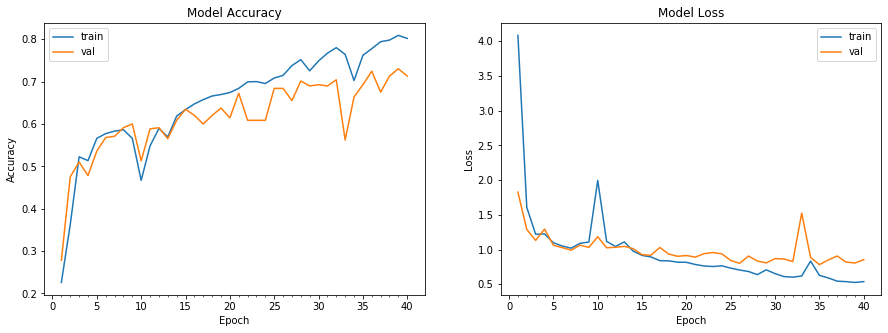

In [0]:
plot_model_history(history)